# Example Classifier Walkthrough

Adapted from Google Keras code example [Image classification from scratch](https://keras.io/examples/vision/image_classification_from_scratch/)

 - Load libraries
 - Getting the data
 - Preprocessing
    - Standard image size
    - Splitting to train/test
 - Train a CNN and evaluate the results
 - Try the model on a new data source

 ## Remember first
 1. Activate a virtual environment `conda env` or `source .venv/bin/activate`
 2. `pip install -r requirements.txt` 

In [ ]:
# Install required packages
# %pip install -r ../requirements.txt -q
# %pip install --upgrade numpy matplotlib pydot tensorflow

# (just for Christopher)
# !apt install libcudnn8

In [22]:
# TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import os
import pydot # NOTE: need graphviz installed in the system
import hashlib
import shutil
import random
import glob

# Create folders if they don't exist
%mkdir -p models
%mkdir -p checkpoints

# Constants
IMAGE_SIZE = (180, 180)
BATCH_SIZE = 128
NUM_CLASSES = 3
ZIP_HASH = 'eedec42a8a363b8ff299a0f2d6eedadafc3af3e7'
MODEL_PATH = 'models/animals.h5'
REBUILD = True
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # 2 for most warnings, 3 to suppress all warnings

# Get the image datasets

All image datasets will be stored in the `3-image_classification/animals` folder

## Option 1 - download zip from data.badmath.org

This is enabled in the next cell.

1. Download zip from data.badmath.org
2. Unzip folder
3. Delete zip file


## Option 2 - manual download from kaggle

This will take some downloading, unzipping, and moving/renaming files and folders.

### "Cat and Dog"
1. Download the dataset from https://www.kaggle.com/datasets/tongpython/cat-and-dog
2. Move the zip into the `animals` folder
3. Unzip it, I've called the folder `animals/cat_and_dog`
4. You should have images such as `animals/cat_and_dog/test_set/cats/cat.4001.jpg`

### "Animal Image Dataset"
1. Download the dataset from https://www.kaggle.com/datasets/ashishsaxena2209/animal-image-datasetdog-cat-and-panda
2. Move the zip into the `animals` folder
3. Unzip it, I've called the folder `animals/animal_images`
4. You should have images such as `animals/animal_images/cats/cats_00001.jpg`


In [23]:
# Download image datasets

# Skip this if you've already got a directory called 'animals' (e.g. if you've run this before)
if not os.path.exists('animals'):
    # Use curl to download the zip if it's not already there
    if not os.path.exists('animals.zip'):
        !curl -L -o animals.zip 'https://data.badmath.org/animals.zip'
        
    
    hash = hashlib.sha1(open('animals.zip', 'rb').read()).hexdigest()
    if (hash == ZIP_HASH):
        print('✅ Download hash validated')
    else:
        raise Exception('❌ ERROR: Download hash does not match!')


    # Unzip the downloaded file into `animals`
    os.mkdir('animals')
    shutil.unpack_archive('animals.zip', 'animals')

    os.remove('animals.zip')

In [24]:
# Check for corrupted images
train = 'animals/cat_and_dog/training_set/'
valid = 'animals/cat_and_dog/test_set/'
world = 'animals/animal_images/'

num_skipped = 0
for data_dir in (train, valid, world):
    for animal in os.listdir(data_dir):
        if os.path.isdir(os.path.join(data_dir, animal)):
            folder_path = os.path.join(data_dir, animal)
            for fname in os.listdir(folder_path):
                fpath = os.path.join(folder_path, fname)
                try:
                    fobj = open(fpath, "rb")
                    is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
                finally:
                    fobj.close()

                if not is_jfif:
                    num_skipped += 1
                    print("Deleted %s" % fpath)
                    # Delete corrupted image
                    os.remove(fpath)


print("Deleted %d images" % num_skipped)

Deleted 0 images


Found 8005 files belonging to 3 classes.
Found 2023 files belonging to 3 classes.
Found 3000 files belonging to 3 classes.


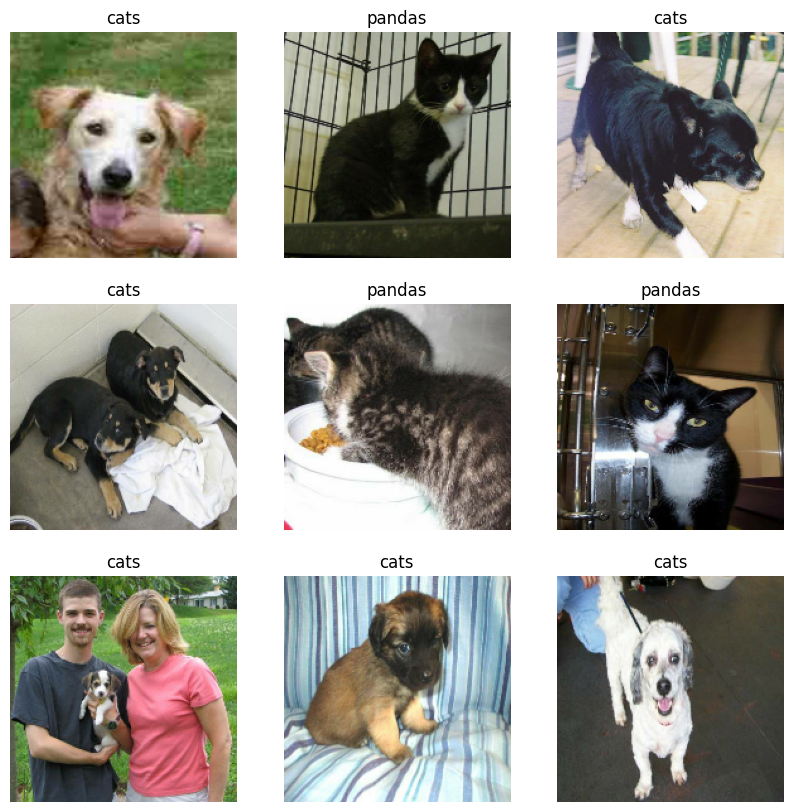

In [25]:
# Set the class names
class_names = os.listdir(train)

train_ds = tf.keras.utils.image_dataset_from_directory(
    train,
    labels='inferred',
    subset=None,
    seed=1337,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)
train_ds = train_ds.map(lambda x, y: (x, tf.one_hot(y, NUM_CLASSES)))

valid_ds = tf.keras.utils.image_dataset_from_directory(
    valid,
    labels='inferred',
    subset=None,
    seed=1337,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)
valid_ds = valid_ds.map(lambda x, y: (x, tf.one_hot(y, NUM_CLASSES)))


world_ds = tf.keras.utils.image_dataset_from_directory(
    world,
    labels='inferred',
    subset=None,
    seed=1337,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)
world_ds = world_ds.map(lambda x, y: (x, tf.one_hot(y, NUM_CLASSES)))


plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[tf.argmax(labels[i])])
        plt.axis("off")


In [26]:
# Find the minimum and maximum dimensions of images in the training set
min_height = 9999
min_width = 9999

for images, labels in train_ds:
    for image in images:
        height, width, _ = image.shape
        if height < min_height:
            min_height = height
        if width < min_width:
            min_width = width

print("Minimum training dimensions:", min_height, "x", min_width)

# Find the minimum and maximum dimensions of images in the validation set
min_height = 9999
min_width = 9999

for images, labels in valid_ds:
    for image in images:
        height, width, _ = image.shape
        if height < min_height:
            min_height = height
        if width < min_width:
            min_width = width

print("Minimum validation dimensions:", min_height, "x", min_width)

Minimum training dimensions: 180 x 180
Minimum validation dimensions: 180 x 180


# Build a model

This code defines a convolutional neural network (CNN) using the Keras library. The network architecture consists of multiple blocks of separable convolutional layers, with residual connections between the blocks. The last layer is a dense layer with either sigmoid or softmax activation, depending on the number of classes. The model is created by calling the make_model function with the input shape and number of classes as arguments, and the resulting model is plotted using keras.utils.plot_model.

This is a simplified version of the Xception architecture (https://arxiv.org/abs/1610.02357).

Here is a quick description of the *layers* in our neural network:
 - `keras.Input(shape=input_shape)` creates an input layer with the specified input shape.
 - `layers.Rescaling(1.0 / 255)` rescales the input values by dividing them by 255.
 - `layers.Conv2D(128, 3, strides=2, padding="same")` creates a 2D convolutional layer with 128 filters, a kernel size of 3x3, a stride of 2, and same padding.
 - `layers.BatchNormalization()` normalizes the outputs of the previous layer to speed up training and reduce overfitting.
 - `layers.Activation("relu")` applies the ReLU activation function to the previous layer's outputs.
 - `layers.SeparableConv2D(size, 3, padding="same")` creates a depthwise separable convolutional layer with size filters, a kernel size of 3x3, and same padding.
 - `layers.MaxPooling2D(3, strides=2, padding="same")` applies max pooling to the previous layer's outputs, reducing their size by a factor of 2.
 - `layers.Conv2D(size, 1, strides=2, padding="same")` creates a 2D convolutional layer with size filters, a kernel size of 1x1, a stride of 2, and same padding.
 - `layers.add([x, residual])` adds the outputs of the previous layer and the residual layer.
 - `layers.GlobalAveragePooling2D()` calculates the average of each feature map in the previous layer's outputs.
 - `layers.Dropout(0.5)` randomly drops out 50% of the previous layer's outputs during training to reduce overfitting.
 - `layers.Dense(units, activation=activation)` creates a fully connected layer with units output nodes and the specified activation function.


In [27]:
# Define a model
# This is a simplified version of the Xception architecture (https://arxiv.org/abs/1610.02357).

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)



In [ ]:
# Train the model

if REBUILD:
  model = make_model(input_shape=IMAGE_SIZE + (3,), num_classes=NUM_CLASSES)

  # Uncomment to show model summary plot
  # keras.utils.plot_model(model, show_shapes=True)

  epochs = 25

  callbacks = [
      keras.callbacks.ModelCheckpoint("checkpoints/save_at_{epoch}.keras"),
  ]
  model.compile(
      optimizer=keras.optimizers.Adam(1e-3),
      # loss="binary_crossentropy",
      loss="categorical_crossentropy",
      metrics=["accuracy"],
  )

  history = model.fit(
      train_ds,
      epochs=epochs,
      callbacks=callbacks,
      validation_data=valid_ds,
  )

  # Save the model
  model.save(MODEL_PATH)
  history.save('models/history.txt')
else:
  if os.path.exists(MODEL_PATH):
    # Load the saved model
    model = keras.models.load_model(MODEL_PATH)
  else:
    !curl -L -o {MODEL_PATH} 'https://data.badmath.org/animals.h5'
    model = keras.models.load_model(MODEL_PATH)


Epoch 1/25


In [17]:
# Now with 100% more plotting!
# Plot the learning curves

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Evaluate the model
val_loss, val_accuracy = model.evaluate(valid_ds)
print(f"Validation loss: {val_loss:.2f}")
print(f"Validation accuracy: {val_accuracy:.2f}")


NameError: ignored

In [ ]:
# Evaluate on the (cat, dog, panda) dataset
world_ds = world_ds.prefetch(buffer_size=32)
model.evaluate(world_ds)

In [ ]:
# Run inference on a new image
img = keras.preprocessing.image.load_img(
    world + 'pandas/panda_00016.jpg',
    target_size=IMAGE_SIZE
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
class_index = tf.argmax(predictions, axis=1)[0]
score = float(predictions[0][class_index])

print(f"This image is a {class_names[class_index]} with a probability of {100 * score:.2f}%.")


In [ ]:
# How well does the model perform on the (cat, dog, panda) dataset? Especially on the pandas?!?

# Get list of all panda image file paths
panda_paths = glob.glob(world + 'pandas/*.jpg')

# Randomly select 9 panda images
sample_panda_paths = random.sample(panda_paths, 9)

# Create subplot for each image
fig, axs = plt.subplots(3, 3, figsize=(10, 10))

# Loop through each image and its corresponding subplot
for i, path in enumerate(sample_panda_paths):
    img = keras.preprocessing.image.load_img(path, target_size=IMAGE_SIZE)
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis
    predictions = model.predict(img_array)
    score = predictions[0]
    class_names = ['cat', 'dog']
    class_index = score.argmax()
    class_name = class_names[class_index]
    prob = score[class_index]
    axs[i//3][i%3].imshow(img_array[0]/255.)
    axs[i//3][i%3].set_title(f"{class_name}: {prob:.2f}")
    axs[i//3][i%3].axis('off')

plt.show()